In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import missingno as msno

import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random
seed_value = 99
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

sns.set_theme(style="darkgrid", context= "paper")

In [3]:
HMDA_clean_final = pd.read_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/HMDA_clean_final.pkl")

In [4]:
HMDA_clean_final['loan_granted'] = (HMDA_clean_final['loan_granted'] == 'Granted').astype(int)

HMDA_encoded = pd.get_dummies(HMDA_clean_final, columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=True)

X = HMDA_encoded.drop(columns=['loan_granted'])
y = HMDA_encoded['loan_granted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [5]:
print(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(545238, 19) (136310, 19) (170388, 19)
(545238,) (136310,) (170388,)


XXX

In [6]:
BLD_train_df = pd.get_dummies(HMDA_clean_final.loc[X_train.index], columns=['applicant_sex', 'applicant_race-1', 'loan_type', 'debt_to_income_ratio', 'lien_status'], drop_first=False)

In [7]:
for col in BLD_train_df.columns:
    if BLD_train_df[col].dtype == 'bool':
        BLD_train_df[col] = BLD_train_df[col].astype(int)

In [8]:
BLD_train_df.head()

county_code  interest_rate  loan_to_value_ratio  loan_granted  \
115410       30013       4.990000           100.000000             1   
630420       48119       4.560661            71.241202             0   
612581       48085       4.560661            71.241202             0   
670964       48085       4.560661            71.241202             1   
179727       30111       7.000000            52.055000             1   

        applicant_sex_Male  applicant_sex_Female  \
115410                   1                     0   
630420                   1                     0   
612581                   1                     0   
670964                   1                     0   
179727                   1                     0   

        applicant_race-1_Black or African American  applicant_race-1_White  \
115410                                           0                       1   
630420                                           1                       0   
612581                                           0                       1   
670964                                           0                       1   
179727                                           0                       1   

        loan_type_Conventional  loan_type_FHA  ...  debt_to_income_ratio_36  \
115410                       0              0  ...                        0   
630420                       1              0  ...                        0   
612581                       1              0  ...                        0   
670964                       1              0  ...                        0   
179727                       1              0  ...                        0   

        debt_to_income_ratio_37%-41%  debt_to_income_ratio_41%-45%  \
115410                             0                             0   
630420                             0                             0   
612581                             0                             0   
670964                             0                             0   
179727                             0                             0   

        debt_to_income_ratio_46%-49%  debt_to_income_ratio_50%-60%  \
115410                             0                             1   
630420                             1                             0   
612581                             0                             0   
670964                             0                             0   
179727                             0                             0   

        debt_to_income_ratio_<20%  debt_to_income_ratio_>60%  \
115410                          0                          0   
630420                          0                          0   
612581                          0                          1   
670964                          1                          0   
179727                          0                          0   

        debt_to_income_ratio_missing  lien_status_First lien  \
115410                             0                       1   
630420                             0                       1   
612581                             0                       0   
670964                             0                       1   
179727                             0                       0   

        lien_status_Subordinate lien  
115410                             0  
630420                             0  
612581                             1  
670964                             0  
179727                             1  

[5 rows x 25 columns]

In [9]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset

pip install 'aif360[inFairness]'


In [10]:
privileged_groups = [{'applicant_race-1_White': 1}]
unprivileged_groups = [{'applicant_race-1_White': 0}]

privileged_groups_2 = [{'applicant_sex_Male': 1}]
unprivileged_groups_2 = [{'applicant_sex_Male': 0}]

train_bld = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_race-1_White', 'applicant_race-1_Black or African American'], favorable_label=1.0, unfavorable_label=0.0)
train_bld_2 = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_sex_Male', 'applicant_sex_Female'], favorable_label=1.0, unfavorable_label=0.0)


metric_orig_train = BinaryLabelDatasetMetric(train_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

metric_orig_train_2 = BinaryLabelDatasetMetric(train_bld_2, 
                                             unprivileged_groups=unprivileged_groups_2,
                                             privileged_groups=privileged_groups_2)

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_orig_train.mean_difference())
print("Difference in mean outcomes between unprivileged and privileged groups - Sex = %f" % metric_orig_train_2.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups - Race = -0.148808
Difference in mean outcomes between unprivileged and privileged groups - Sex = -0.036731


In [11]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(train_bld)

In [12]:
class_weights_array = dataset_transf_train.instance_weights

In [13]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print(metric_orig_train.disparate_impact())
print(metric_transf_train.disparate_impact())

print("Difference in mean outcomes between unprivileged and privileged groups - Race = %f" % metric_transf_train.mean_difference())

0.7528037780827889
0.9999999999999997
Difference in mean outcomes between unprivileged and privileged groups - Race = -0.000000


In [14]:
print(pd.DataFrame(train_bld.convert_to_dataframe()[0][["county_code", "interest_rate", "loan_to_value_ratio"]]).head(), "\n", "\n", X_train[["county_code", "interest_rate", "loan_to_value_ratio"]].head())

        county_code  interest_rate  loan_to_value_ratio
115410      30013.0       4.990000           100.000000
630420      48119.0       4.560661            71.241202
612581      48085.0       4.560661            71.241202
670964      48085.0       4.560661            71.241202
179727      30111.0       7.000000            52.055000 
 
        county_code  interest_rate  loan_to_value_ratio
115410       30013       4.990000           100.000000
630420       48119       4.560661            71.241202
612581       48085       4.560661            71.241202
670964       48085       4.560661            71.241202
179727       30111       7.000000            52.055000


In [15]:
X_train.astype(float).describe()

county_code  interest_rate  loan_to_value_ratio  \
count  545238.000000  545238.000000        545238.000000   
mean    43877.231382       4.560750            71.250975   
std      9573.854372       1.207122            18.529292   
min     22001.000000       0.000000             0.000000   
25%     48029.000000       4.560661            71.241202   
50%     48201.000000       4.560661            71.241202   
75%     48439.000000       4.740000            78.247750   
max     49057.000000      18.990000           250.000000   

       applicant_sex_Female  applicant_race-1_White  loan_type_FHA  \
count         545238.000000           545238.000000  545238.000000   
mean               0.347368                0.845618       0.105189   
std                0.476134                0.361315       0.306797   
min                0.000000                0.000000       0.000000   
25%                0.000000                1.000000       0.000000   
50%                0.000000                1.000000       0.000000   
75%                1.000000                1.000000       0.000000   
max                1.000000                1.000000       1.000000   

        loan_type_VA  loan_type_FSA/RHS  debt_to_income_ratio_20%-<30%  \
count  545238.000000      545238.000000                  545238.000000   
mean        0.070549           0.008565                       0.141551   
std         0.256070           0.092151                       0.348589   
min         0.000000           0.000000                       0.000000   
25%         0.000000           0.000000                       0.000000   
50%         0.000000           0.000000                       0.000000   
75%         0.000000           0.000000                       0.000000   
max         1.000000           1.000000                       1.000000   

       debt_to_income_ratio_30%-<36%  debt_to_income_ratio_36  \
count                  545238.000000            545238.000000   
mean                        0.121288                 0.022484   
std                         0.326462                 0.148251   
min                         0.000000                 0.000000   
25%                         0.000000                 0.000000   
50%                         0.000000                 0.000000   
75%                         0.000000                 0.000000   
max                         1.000000                 1.000000   

       debt_to_income_ratio_37%-41%  debt_to_income_ratio_41%-45%  \
count                 545238.000000                 545238.000000   
mean                       0.140509                      0.120303   
std                        0.347515                      0.325316   
min                        0.000000                      0.000000   
25%                        0.000000                      0.000000   
50%                        0.000000                      0.000000   
75%                        0.000000                      0.000000   
max                        1.000000                      1.000000   

       debt_to_income_ratio_46%-49%  debt_to_income_ratio_50%-60%  \
count                 545238.000000                 545238.000000   
mean                       0.091378                      0.098418   
std                        0.288147                      0.297879   
min                        0.000000                      0.000000   
25%                        0.000000                      0.000000   
50%                        0.000000                      0.000000   
75%                        0.000000                      0.000000   
max                        1.000000                      1.000000   

       debt_to_income_ratio_<20%  debt_to_income_ratio_>60%  \
count              545238.000000              545238.000000   
mean                    0.051739                   0.188516   
std                     0.221500                   0.391124   
min                     0.000000                   0.000000   
25%                     0

In [16]:
'''
directory = 'C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/'

os.makedirs(directory, exist_ok=True)

pickle_file = os.path.join(directory, 'subsets_data.pickle')

subsets = {
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'X_val_scaled': X_val_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'y_val': y_val
}

with open(pickle_file, 'wb') as f:
    pickle.dump(subsets, f)
'''

"\ndirectory = 'C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/'\n\nos.makedirs(directory, exist_ok=True)\n\npickle_file = os.path.join(directory, 'subsets_data.pickle')\n\nsubsets = {\n    'X_train_scaled': X_train_scaled,\n    'X_test_scaled': X_test_scaled,\n    'X_val_scaled': X_val_scaled,\n    'y_train': y_train,\n    'y_test': y_test,\n    'y_val': y_val\n}\n\nwith open(pickle_file, 'wb') as f:\n    pickle.dump(subsets, f)\n"

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early_stopping_rew = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model_checkpoint_rew = ModelCheckpoint('best_model_rew.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model = keras.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])

model_rew = keras.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=30, batch_size=48, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
11360/11360 [==============================] - 47s 4ms/step - loss: 0.4216 - accuracy: 0.8152 - val_loss: 0.3778 - val_accuracy: 0.8356
Epoch 2/30
11360/11360 [==============================] - 24s 2ms/step - loss: 0.3818 - accuracy: 0.8309 - val_loss: 0.3738 - val_accuracy: 0.8312
Epoch 3/30
11360/11360 [==============================] - 26s 2ms/step - loss: 0.3753 - accuracy: 0.8335 - val_loss: 0.3630 - val_accuracy: 0.8378
Epoch 4/30
11360/11360 [==============================] - 24s 2ms/step - loss: 0.3715 - accuracy: 0.8353 - val_loss: 0.3612 - val_accuracy: 0.8404
Epoch 5/30
11360/11360 [==============================] - 26s 2ms/step - loss: 0.3703 - accuracy: 0.8362 - val_loss: 0.3606 - val_accuracy: 0.8409
Epoch 6/30
11360/11360 [==============================] - 25s 2ms/step - loss: 0.3680 - accuracy: 0.8370 - val_loss: 0.3630 - val_accuracy: 0.8396
Epoch 7/30
11360/11360 [==============================] - 24s 2ms/step - loss: 0.3673 - accuracy: 0.8372 - val_loss: 0

In [18]:
# show a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [19]:
model_rew.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_rew = model_rew.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=30, batch_size=48, callbacks=[early_stopping_rew, model_checkpoint_rew], sample_weight=class_weights_array)

Epoch 1/30
11360/11360 [==============================] - 26s 2ms/step - loss: 0.4255 - accuracy: 0.8117 - val_loss: 0.3920 - val_accuracy: 0.8263
Epoch 2/30
11360/11360 [==============================] - 32s 3ms/step - loss: 0.3884 - accuracy: 0.8277 - val_loss: 0.3862 - val_accuracy: 0.8253
Epoch 3/30
11360/11360 [==============================] - 35s 3ms/step - loss: 0.3832 - accuracy: 0.8293 - val_loss: 0.3702 - val_accuracy: 0.8335
Epoch 4/30
11360/11360 [==============================] - 36s 3ms/step - loss: 0.3785 - accuracy: 0.8319 - val_loss: 0.3688 - val_accuracy: 0.8341
Epoch 5/30
11360/11360 [==============================] - 35s 3ms/step - loss: 0.3759 - accuracy: 0.8322 - val_loss: 0.3646 - val_accuracy: 0.8374
Epoch 6/30
11360/11360 [==============================] - 27s 2ms/step - loss: 0.3740 - accuracy: 0.8332 - val_loss: 0.3696 - val_accuracy: 0.8361
Epoch 7/30
11360/11360 [==============================] - 25s 2ms/step - loss: 0.3730 - accuracy: 0.8334 - val_loss: 0

5325/5325 - 6s - loss: 0.3575 - accuracy: 0.8434 - 6s/epoch - 1ms/step
5325/5325 - 9s - loss: 0.3586 - accuracy: 0.8412 - 9s/epoch - 2ms/step

Test accuracy: 0.8433809876441956

Test accuracy reweighted: 0.8411625027656555


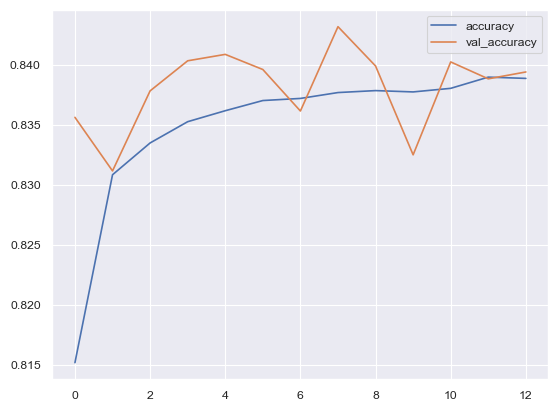

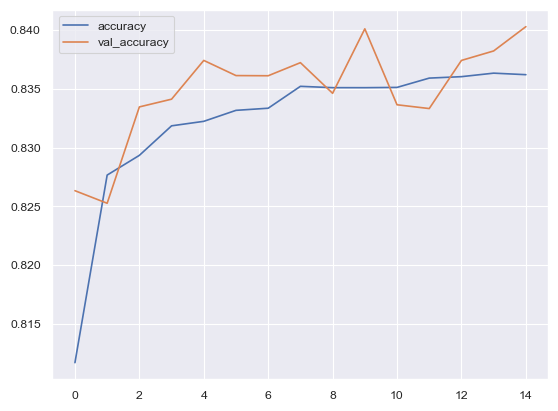

In [20]:
history_df = pd.DataFrame(history.history)
history_df_rew = pd.DataFrame(history_rew.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
history_df_rew.loc[:, ['accuracy', 'val_accuracy']].plot()

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
test_loss_rew, test_acc_rew = model_rew.evaluate(X_test_scaled, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest accuracy reweighted:', test_acc_rew)

5325/5325 [==============================] - 10s 2ms/step
[[52145 19503]
 [ 7183 91557]]
[[50590 21058]
 [ 6006 92734]]
Accuracy: 0.8433809892715449
Precision: 0.8243922204213938
Recall: 0.9272533927486327
F1 Score: 0.8728026692087701
Accuracy reweighted: 0.8411625231823837
Precision reweighted: 0.8149430539932508
Recall reweighted: 0.9391735871987037
F1 Score reweighted: 0.8726591760299626
AUC: 0.918699533138311
AUC reweighted: 0.918690032781176


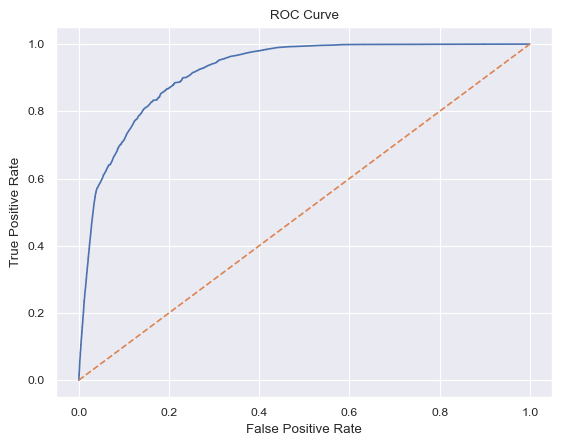

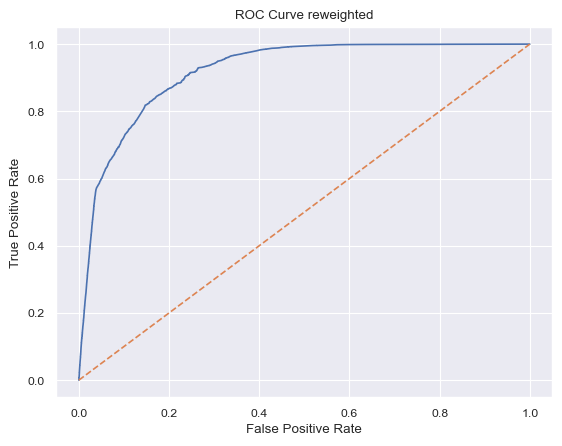

In [21]:
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5)
y_pred_proba = y_pred_proba.ravel()

y_pred_proba_rew = model_rew.predict(X_test_scaled)
y_pred_rew = (y_pred_proba_rew > 0.5)
y_pred_proba_rew = y_pred_proba_rew.ravel()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

cm_rew = confusion_matrix(y_test, y_pred_rew)
print(cm_rew)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("Accuracy reweighted:", accuracy_score(y_test, y_pred_rew))
print("Precision reweighted:", precision_score(y_test, y_pred_rew))
print("Recall reweighted:", recall_score(y_test, y_pred_rew))
print("F1 Score reweighted:", f1_score(y_test, y_pred_rew))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fprr, tprr, thresholdsr = roc_curve(y_test, y_pred_proba_rew)

from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score(y_test, y_pred_proba))

print("AUC reweighted:", roc_auc_score(y_test, y_pred_proba_rew))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

plt.plot(fprr, tprr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve reweighted')
plt.show()

In [22]:
results = pd.DataFrame({'label': y_test})
results["score"] = y_pred.astype(int)
results["applicant_sex"] = HMDA_clean_final.loc[results.index, "applicant_sex"]
results["applicant_race-1"] = HMDA_clean_final.loc[results.index, "applicant_race-1"]

results_rew = pd.DataFrame({'label': y_test})
results_rew["score"] = y_pred_rew.astype(int)
results_rew["applicant_sex"] = HMDA_clean_final.loc[results_rew.index, "applicant_sex"]
results_rew["applicant_race-1"] = HMDA_clean_final.loc[results_rew.index, "applicant_race-1"]

results["label"] = results["label"].astype("int")
results["score"] = results["score"].astype("int")

results_rew["label"] = results_rew["label"].astype("int")
results_rew["score"] = results_rew["score"].astype("int")

results["applicant_sex"] = results["applicant_sex"].astype("object")
results["applicant_race-1"] = results["applicant_race-1"].astype("object")

results_rew["applicant_sex"] = results_rew["applicant_sex"].astype("object")
results_rew["applicant_race-1"] = results_rew["applicant_race-1"].astype("object")

In [23]:
print(results.head(), "\n", results.shape, "\n", results.dtypes, "\n", results_rew.head(), "\n", results_rew.shape, "\n", results_rew.dtypes)

        label  score applicant_sex           applicant_race-1
238575      1      1          Male                      White
328268      0      0          Male                      White
594872      1      1          Male                      White
635106      1      1          Male                      White
451212      0      0        Female  Black or African American 
 (170388, 4) 
 label                int32
score                int32
applicant_sex       object
applicant_race-1    object
dtype: object 
         label  score applicant_sex           applicant_race-1
238575      1      1          Male                      White
328268      0      0          Male                      White
594872      1      1          Male                      White
635106      1      1          Male                      White
451212      0      1        Female  Black or African American 
 (170388, 4) 
 label                int32
score                int32
applicant_sex       object
applicant_race-1   

In [24]:
import aequitas

audit = aequitas.Audit(results)
audit_rew = aequitas.Audit(results_rew)

In [25]:
g = aequitas.group.Group()

results_ren = results.copy()
results_ren["label_value"] = results["label"]
results_ren.drop(columns="label", inplace=True)

results_ren_rew = results_rew.copy()
results_ren_rew["label_value"] = results_rew["label"]
results_ren_rew.drop(columns="label", inplace=True)

xtab, _ = g.get_crosstabs(results_ren)
xtab_rew, _ = g.get_crosstabs(results_ren_rew)

In [26]:
absolute_metrics = g.list_absolute_metrics(xtab)
absolute_metrics_rew = g.list_absolute_metrics(xtab_rew)

In [27]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

attribute_name            attribute_value  accuracy   tpr   tnr   for  \
0     applicant_sex                     Female      0.86  0.93  0.77  0.10   
1     applicant_sex                       Male      0.83  0.92  0.70  0.14   
2  applicant_race-1  Black or African American      0.82  0.81  0.83  0.16   
3  applicant_race-1                      White      0.85  0.94  0.70  0.11   

    fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.16  0.23  0.07  0.90       0.84  0.33   0.62  0.56  
1  0.18  0.30  0.08  0.86       0.82  0.67   0.67  0.59  
2  0.20  0.17  0.19  0.84       0.80  0.11   0.46  0.45  
3  0.17  0.30  0.06  0.89       0.83  0.89   0.69  0.60

In [28]:
xtab_rew[['attribute_name', 'attribute_value'] + absolute_metrics_rew].round(2)

attribute_name            attribute_value  accuracy   tpr   tnr   for  \
0     applicant_sex                     Female      0.86  0.94  0.75  0.09   
1     applicant_sex                       Male      0.83  0.94  0.68  0.12   
2  applicant_race-1  Black or African American      0.80  0.92  0.71  0.09   
3  applicant_race-1                      White      0.85  0.94  0.71  0.11   

    fdr   fpr   fnr   npv  precision   ppr  pprev  prev  
0  0.17  0.25  0.06  0.91       0.83  0.33   0.63  0.56  
1  0.19  0.32  0.06  0.88       0.81  0.67   0.69  0.59  
2  0.28  0.29  0.08  0.91       0.72  0.13   0.58  0.45  
3  0.17  0.29  0.06  0.89       0.83  0.87   0.68  0.60

In [29]:
aqp = aequitas.plotting.Plot()

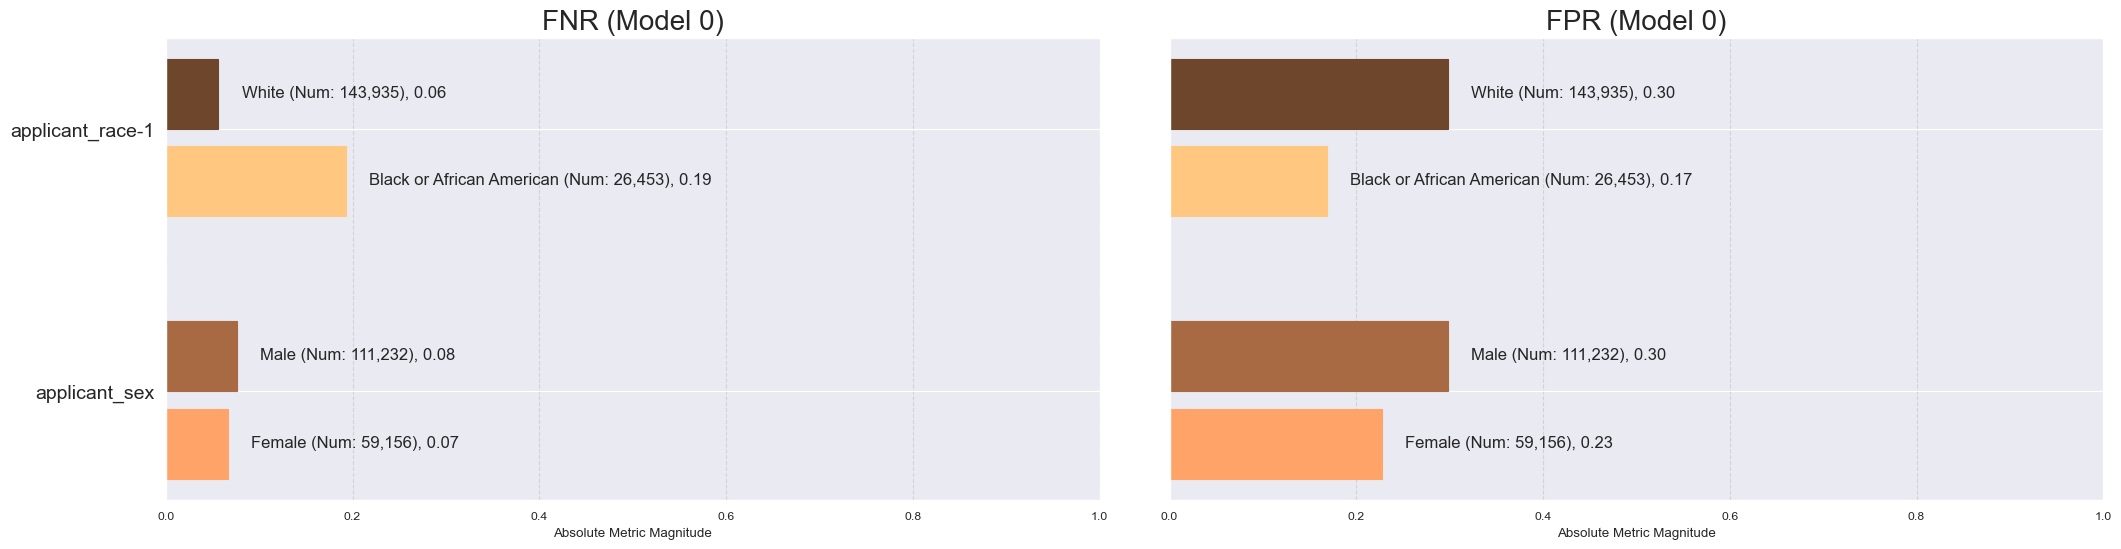

<Figure size 640x480 with 0 Axes>

In [59]:
group_metric_all = aqp.plot_group_metric_all(xtab, metrics=['fnr','fpr'], ncols=2)

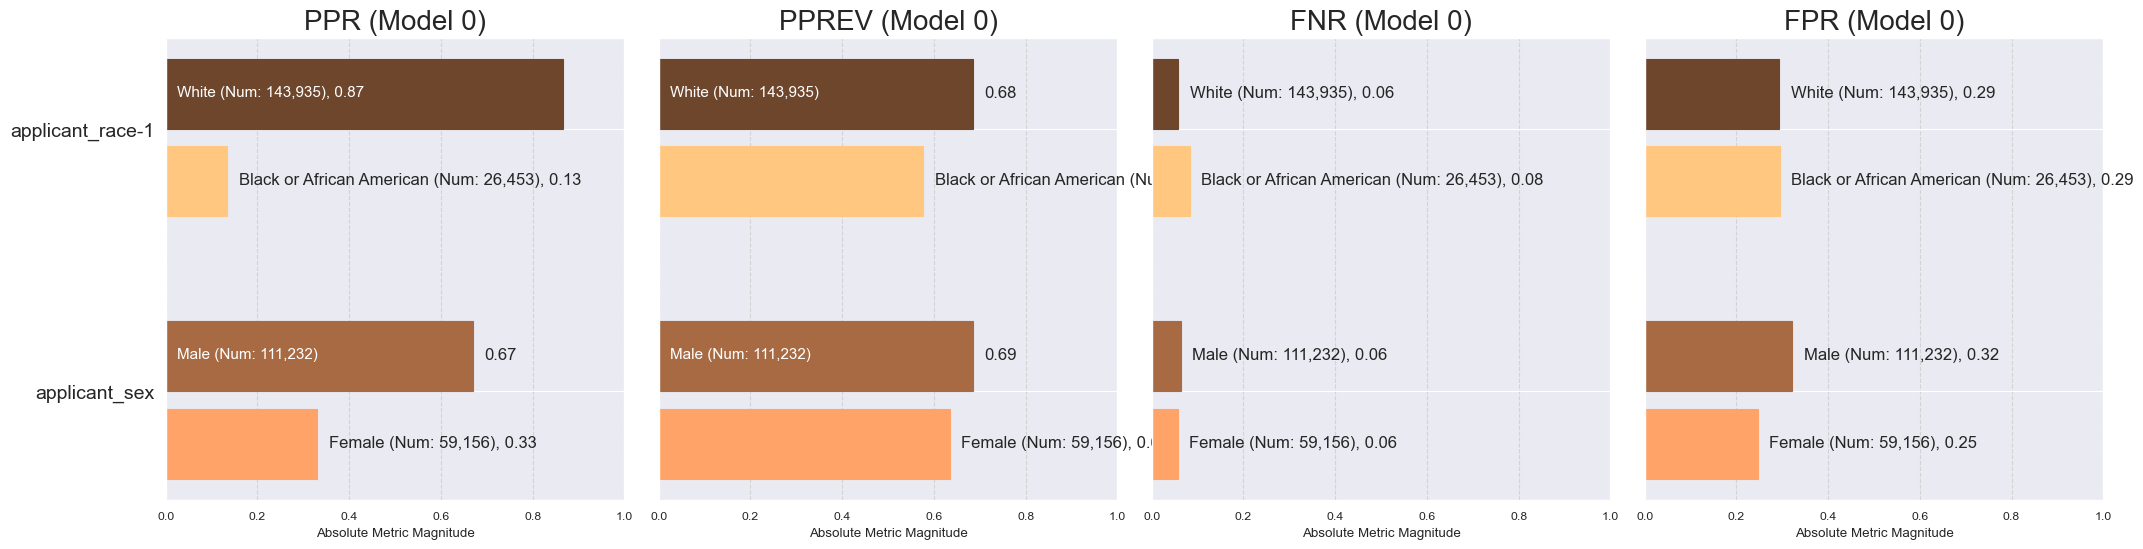

<Figure size 640x480 with 0 Axes>

In [31]:
group_metric_all_rew = aqp.plot_group_metric_all(xtab_rew, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

In [32]:
b = aequitas.bias.Bias()

In [33]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=results_ren, ref_groups_dict={'applicant_race-1':'White', 'applicant_sex':'Male'}, alpha=0.05, mask_significance=True)
bdf.style

In [34]:
bdf_rew = b.get_disparity_predefined_groups(xtab_rew, original_df=results_ren_rew, ref_groups_dict={'applicant_race-1':'White', 'applicant_sex': 'Male'}, alpha=0.05, mask_significance=True)
bdf_rew.style

In [76]:
original_model_results_total = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1': [f1_score(y_test, y_pred)],
    'roc_auc': [roc_auc_score(y_test, y_pred_proba)],
    'tpr_disparity': [bdf['tpr_disparity'][2]],
    'fpr_disparity': [bdf['fpr_disparity'][2]],
    'tnr_disparity': [bdf['tnr_disparity'][2]],
    'fpr_disparity': [bdf['fpr_disparity'][2]]
})

In [77]:
original_model_results_total_rew = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, y_pred_rew)],
    'precision': [precision_score(y_test, y_pred_rew)],
    'recall': [recall_score(y_test, y_pred_rew)],
    'f1': [f1_score(y_test, y_pred_rew)],
    'roc_auc': [roc_auc_score(y_test, y_pred_proba_rew)],
    'tpr_disparity': [bdf_rew['tpr_disparity'][2]],
    'fpr_disparity': [bdf_rew['fpr_disparity'][2]],
    'tnr_disparity': [bdf_rew['tnr_disparity'][2]],
    'fpr_disparity': [bdf_rew['fpr_disparity'][2]]
})

In [78]:
results_df = pd.concat([original_model_results_total, original_model_results_total_rew], axis=0)
results_df.index = ['Initial_Model', 'Iteration I']
results_df = results_df.T
results_df

Initial_Model  Iteration I
accuracy            0.843381     0.841163
precision           0.824392     0.814943
recall              0.927253     0.939174
f1                  0.872803     0.872659
roc_auc             0.918700     0.918690
tpr_disparity       0.854902     0.972778
fpr_disparity       0.565432     1.000872
tnr_disparity       1.184800     0.999637

In [35]:
import shap

def f(X):
    return model.predict([X[:, i] for i in range(X.shape[1])]).flatten()

In [36]:
shap.initjs()
explainer = shap.KernelExplainer(model.predict ,shap.sample(X_train_scaled, 100))

4/4 [==============================] - 0s 3ms/step


In [37]:
shap.initjs()
tf.autograph.set_verbosity(0)
shap_values = explainer.shap_values(X_test_scaled[:150], nsamples=150)

  0%|          | 0/150 [00:00<?, ?it/s]

469/469 [==============================] - 1s 1ms/step


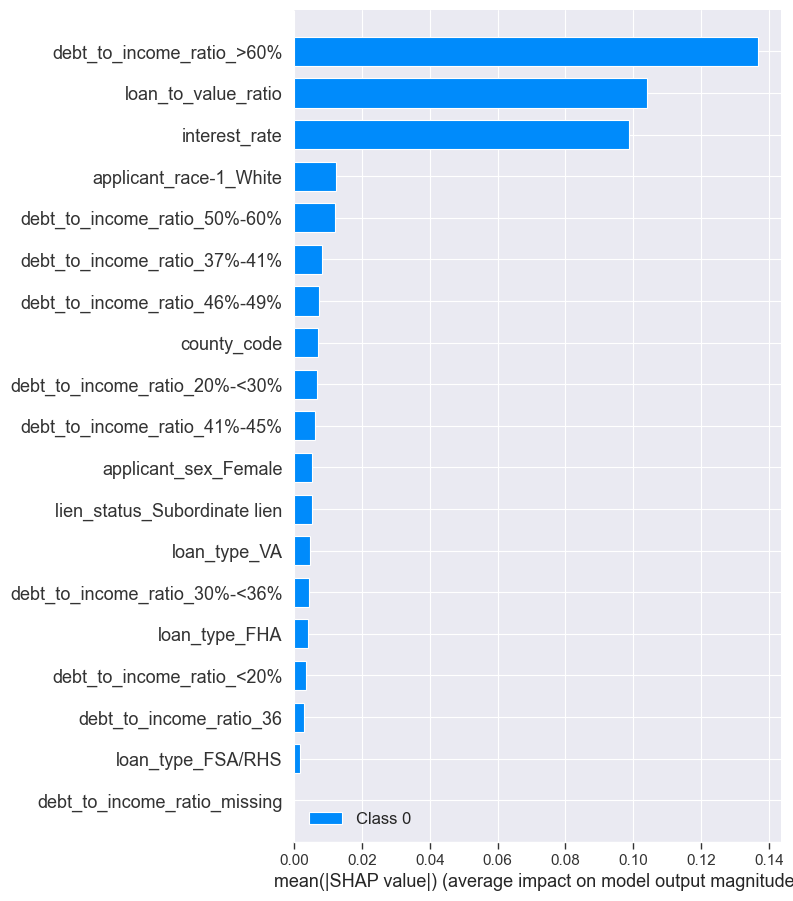

In [38]:
shap.summary_plot(shap_values, X_test_scaled[:150], feature_names=X.columns)

In [39]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test_scaled[:150], feature_names=X.columns)

In [40]:
explainer.expected_value

array([0.5783024])

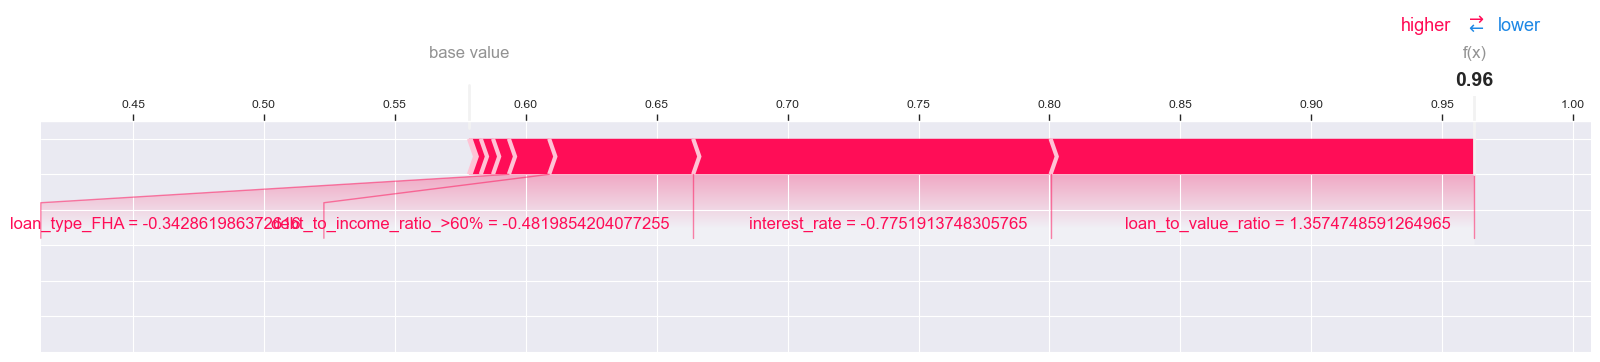

In [41]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0][0], X_test_scaled[0], feature_names=X.columns, matplotlib=True)

In [42]:
for value in range(10):
    print(str(value) + ": Base value", explainer.expected_value, "Shapley value", shap_values[0][value].sum(), "Sum", shap_values[0][value].sum() + explainer.expected_value)

0: Base value [0.5783024] Shapley value 0.3840415947241855 Sum [0.96234399]
1: Base value [0.5783024] Shapley value -0.5767629836583364 Sum [0.00153941]
2: Base value [0.5783024] Shapley value 0.29768036530447717 Sum [0.87598276]
3: Base value [0.5783024] Shapley value 0.09323792384100671 Sum [0.67154032]
4: Base value [0.5783024] Shapley value -0.3967065341668058 Sum [0.18159586]
5: Base value [0.5783024] Shapley value -0.5768155180513713 Sum [0.00148688]
6: Base value [0.5783024] Shapley value 0.3512173764510226 Sum [0.92951977]
7: Base value [0.5783024] Shapley value 0.3544646374983858 Sum [0.93276703]
8: Base value [0.5783024] Shapley value 0.380088733891971 Sum [0.95839113]
9: Base value [0.5783024] Shapley value 0.12215458081198449 Sum [0.70045698]


In [43]:
y_pred_proba[:10]

array([0.962344  , 0.00153941, 0.87598276, 0.6715404 , 0.18159586,
       0.00148688, 0.92951983, 0.9327671 , 0.9583911 , 0.700457  ],
      dtype=float32)

In [44]:
pd.DataFrame(sorted(dict(zip(X.columns, shap_values[0][0])).items(), key=lambda x: x[1], reverse=True))

0         1
0             loan_to_value_ratio  0.161904
1                   interest_rate  0.136509
2       debt_to_income_ratio_>60%  0.054989
3                   loan_type_FHA  0.015390
4    debt_to_income_ratio_37%-41%  0.006060
5    debt_to_income_ratio_50%-60%  0.004659
6    debt_to_income_ratio_41%-45%  0.003913
7          applicant_race-1_White  0.000616
8                     county_code  0.000000
9            applicant_sex_Female  0.000000
10                   loan_type_VA  0.000000
11              loan_type_FSA/RHS  0.000000
12  debt_to_income_ratio_20%-<30%  0.000000
13  debt_to_income_ratio_30%-<36%  0.000000
14        debt_to_income_ratio_36  0.000000
15   debt_to_income_ratio_46%-49%  0.000000
16      debt_to_income_ratio_<20%  0.000000
17   debt_to_income_ratio_missing  0.000000
18   lien_status_Subordinate lien  0.000000

In [45]:
explainer_rew = shap.KernelExplainer(model_rew.predict ,shap.sample(X_train_scaled, 100))
shap_values_rew = explainer_rew.shap_values(X_test_scaled[:150], nsamples=150)

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/150 [00:00<?, ?it/s]

469/469 [==============================] - 1s 1ms/step


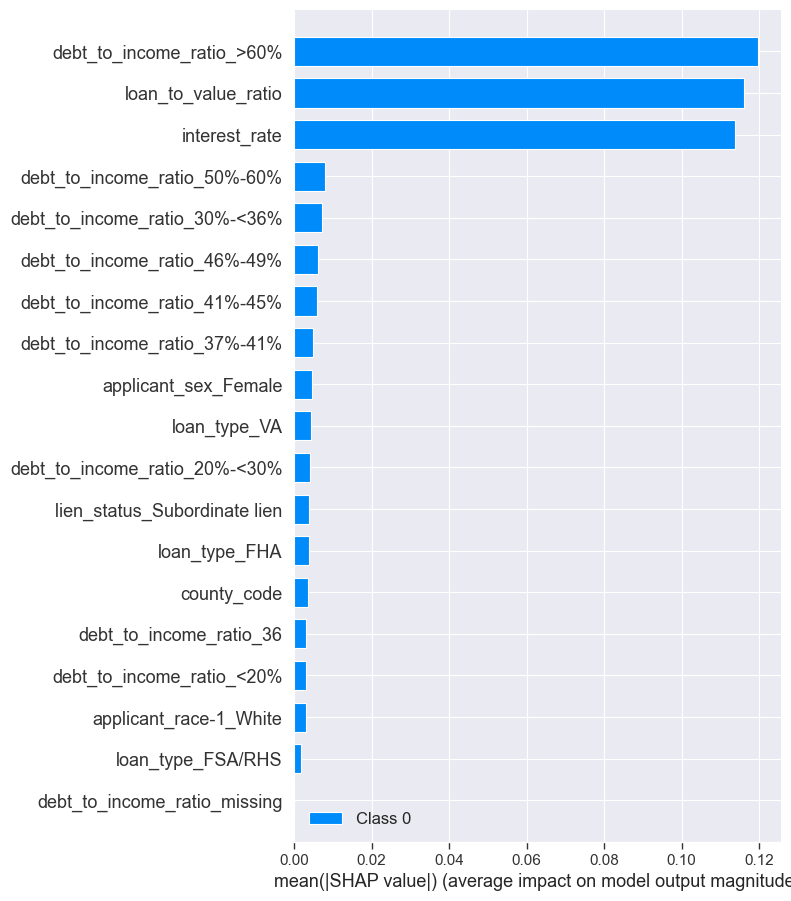

In [46]:
shap.summary_plot(shap_values_rew, X_test_scaled[:150], feature_names=X.columns)

In [47]:
shap.force_plot(explainer_rew.expected_value, shap_values_rew[0], X_test_scaled[:150], feature_names=X.columns)

In [48]:
explainer_rew.expected_value

array([0.59478389])

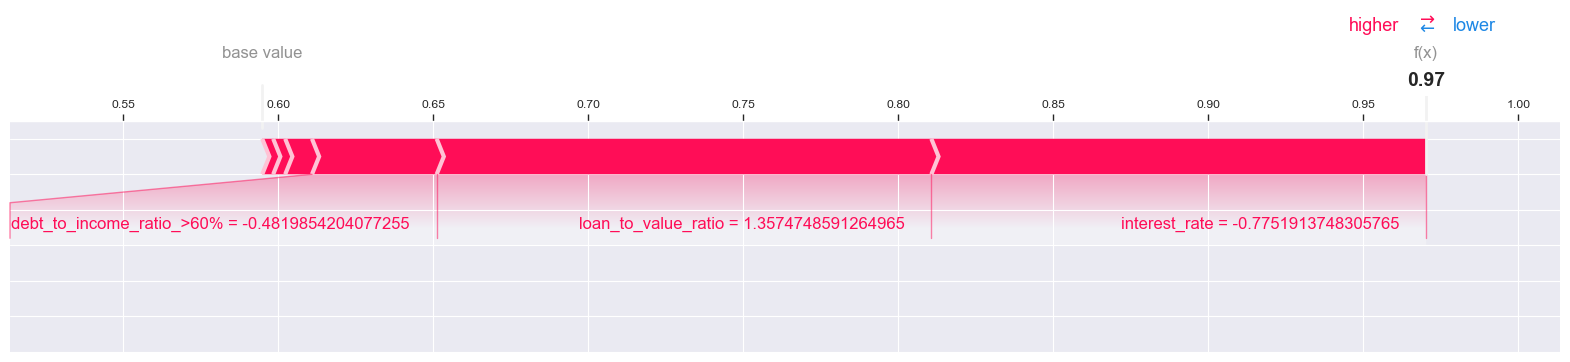

In [49]:
shap.initjs()
shap.force_plot(explainer_rew.expected_value, shap_values_rew[0][0], X_test_scaled[0], feature_names=X.columns, matplotlib=True)

In [50]:
print("Reweighed")
for value in range(10):
    print(str(value) + ": Base value", explainer_rew.expected_value, "Shapley value", shap_values_rew[0][value].sum(), "Sum", shap_values_rew[0][value].sum() + explainer_rew.expected_value)
print("Original")
for value in range(10):
    print(str(value) + ": Base value", explainer.expected_value, "Shapley value", shap_values[0][value].sum(), "Sum", shap_values[0][value].sum() + explainer.expected_value)

Reweighed
0: Base value [0.59478389] Shapley value 0.3754469892778435 Sum [0.97023088]
1: Base value [0.59478389] Shapley value -0.5917074039275757 Sum [0.00307648]
2: Base value [0.59478389] Shapley value 0.38224185917759324 Sum [0.97702575]
3: Base value [0.59478389] Shapley value 0.1295840284624138 Sum [0.72436792]
4: Base value [0.59478389] Shapley value -0.059751854201313015 Sum [0.53503203]
5: Base value [0.59478389] Shapley value -0.5916824447154067 Sum [0.00310144]
6: Base value [0.59478389] Shapley value 0.3701138040819206 Sum [0.96489769]
7: Base value [0.59478389] Shapley value 0.37077273342991257 Sum [0.96555662]
8: Base value [0.59478389] Shapley value 0.3682721397676506 Sum [0.96305603]
9: Base value [0.59478389] Shapley value 0.1175685665407219 Sum [0.71235245]
Original
0: Base value [0.5783024] Shapley value 0.3840415947241855 Sum [0.96234399]
1: Base value [0.5783024] Shapley value -0.5767629836583364 Sum [0.00153941]
2: Base value [0.5783024] Shapley value 0.297680365

In [51]:
pd.DataFrame(sorted(dict(zip(X.columns, shap_values_rew[0][0])).items(), key=lambda x: x[1], reverse=True))

0         1
0                   interest_rate  0.159608
1             loan_to_value_ratio  0.159575
2       debt_to_income_ratio_>60%  0.040219
3   debt_to_income_ratio_30%-<36%  0.008636
4    debt_to_income_ratio_50%-60%  0.003876
5    debt_to_income_ratio_37%-41%  0.003533
6                     county_code  0.000000
7            applicant_sex_Female  0.000000
8          applicant_race-1_White  0.000000
9                   loan_type_FHA  0.000000
10                   loan_type_VA  0.000000
11              loan_type_FSA/RHS  0.000000
12  debt_to_income_ratio_20%-<30%  0.000000
13        debt_to_income_ratio_36  0.000000
14   debt_to_income_ratio_41%-45%  0.000000
15   debt_to_income_ratio_46%-49%  0.000000
16      debt_to_income_ratio_<20%  0.000000
17   debt_to_income_ratio_missing  0.000000
18   lien_status_Subordinate lien  0.000000

In [52]:
shap_diff_race_orig = []
for i in range(15):
    shap_diff_race_orig.append(shap_values[0][i][4])

shap_diff_race_rew = []
for i in range(15):
    shap_diff_race_rew.append(shap_values_rew[0][i][4])

pd.DataFrame({'Original': shap_diff_race_orig, 'Reweighed': shap_diff_race_rew})

Original  Reweighed
0   0.000616   0.000000
1   0.000000   0.000000
2   0.000000   0.000000
3   0.029517   0.007319
4   0.000000   0.000000
5   0.000000   0.000000
6   0.000514   0.000000
7   0.010442   0.007896
8   0.000000   0.000000
9   0.000000   0.000000
10 -0.030064  -0.007807
11  0.029243   0.000000
12 -0.057495  -0.022498
13  0.001294   0.000000
14 -0.035410  -0.029565

In [53]:
import lime.lime_tabular

In [54]:
lime_exp = lime.lime_tabular.LimeTabularExplainer(X_train_scaled, mode="classification", feature_names=X.columns)

In [55]:
explained_lime = lime_exp.explain_instance(X_test_scaled[0], model.predict, num_features=15, top_labels=1)

157/157 [==============================] - 0s 1ms/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


In [56]:
explained_lime.show_in_notebook(show_table=True, show_all=False)